In [6]:
!pip install tensorflow
!pip install keras


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [32]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Resizing, Rescaling
import matplotlib.pyplot as plt

In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='Potato',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [15]:
class_names = dataset.class_names
class_names

['Test', 'Train', 'Valid']

In [16]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[152.98824  141.98824  157.98824 ]
  [150.98433  139.98433  155.98433 ]
  [148.98822  137.98822  153.98822 ]
  ...
  [149.01173  141.01173  156.01173 ]
  [151.98434  143.98434  158.98434 ]
  [154.99414  146.99414  161.99414 ]]

 [[148.98824  137.98824  153.98824 ]
  [148.98238  137.98238  153.98238 ]
  [147.98442  136.98442  152.98442 ]
  ...
  [150.00583  142.00583  157.00583 ]
  [152.9824   144.9824   159.9824  ]
  [154.9961   146.9961   161.9961  ]]

 [[147.00983  136.00983  152.00983 ]
  [147.0196   136.0196   152.0196  ]
  [147.02933  136.02933  152.02933 ]
  ...
  [151.00981  143.00981  158.00981 ]
  [152.98837  144.98837  159.98837 ]
  [154.98631  146.98631  161.98631 ]]

 ...

 [[112.0509   104.0509   117.0509  ]
  [113.0118   105.0118   118.0118  ]
  [110.01977  102.01977  115.01977 ]
  ...
  [146.77507  139.77507  147.77507 ]
  [142.09726  135.09726  143.09726 ]
  [147.02948  140.02948  148.02948 ]]

 [[109.0

In [17]:
len(class_names)

3

# Visualize some of the images from our dataset

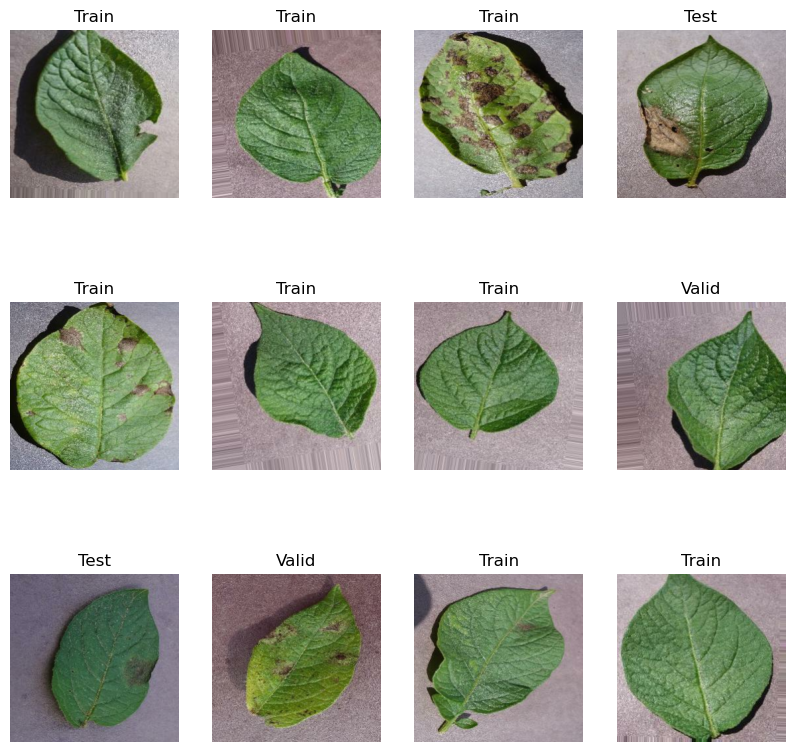

In [18]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [19]:
len(dataset)

47

In [20]:
train_size = 0.8
len(dataset) * train_size

37.6

In [21]:
train_ds = dataset.take(54)
len(train_ds)

47

In [22]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [23]:
val_size = 0.1
len(dataset)*val_size

4.7

In [24]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [25]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds)

37

In [28]:
len(val_ds)

4

In [29]:
len(test_ds)

6

# Cache, Shuffle, and Prefetch the Dataset
additional transformations is commonly used in TensorFlow to optimize the performance of the input pipeline when training machine learning models

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [38]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [39]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [41]:
model = models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),  # Define input layer
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 253, 253, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5474 - loss: 1.0412 - val_accuracy: 0.5938 - val_loss: 0.9611
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5980 - loss: 0.9581 - val_accuracy: 0.5938 - val_loss: 0.9547
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6115 - loss: 0.9405 - val_accuracy: 0.5938 - val_loss: 0.9558
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6185 - loss: 0.9310 - val_accuracy: 0.5938 - val_loss: 0.9545
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.6228 - loss: 0.9306 - val_accuracy: 0.5938 - val_loss: 0.9556
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6121 - loss: 0.9390 - val_accuracy: 0.5938 - val_loss: 0.9746
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5888 - loss: 0.9814 - val_accuracy: 0.5938 - val_loss: 0.9694
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5891 - loss: 0.9659 - val_accuracy: 0.5938 - val_loss:

In [45]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.6122 - loss: 0.9374


In [46]:
model.save("model.h5")

# Plotting the Accuracy and Loss Curves

In [47]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 37}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0046182870864868,
 0.9497389793395996,
 0.9481552839279175,
 0.9468899965286255,
 0.9473636746406555]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

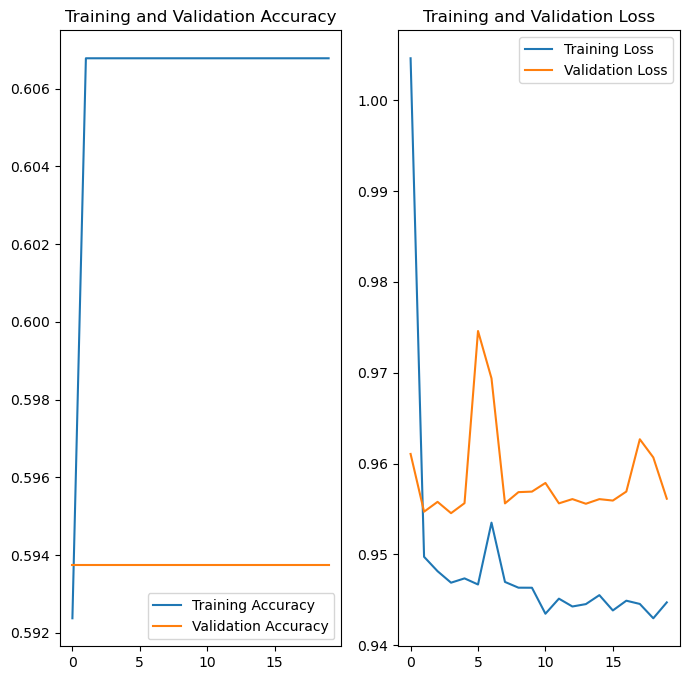

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

In [51]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Test
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
predicted label: Train


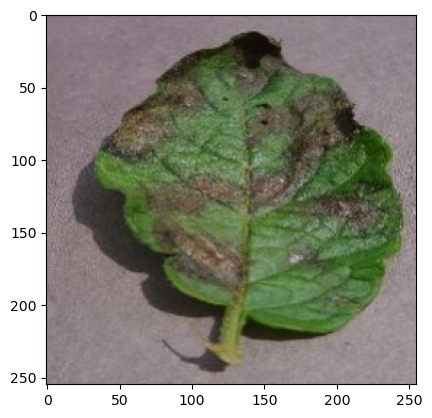

In [52]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


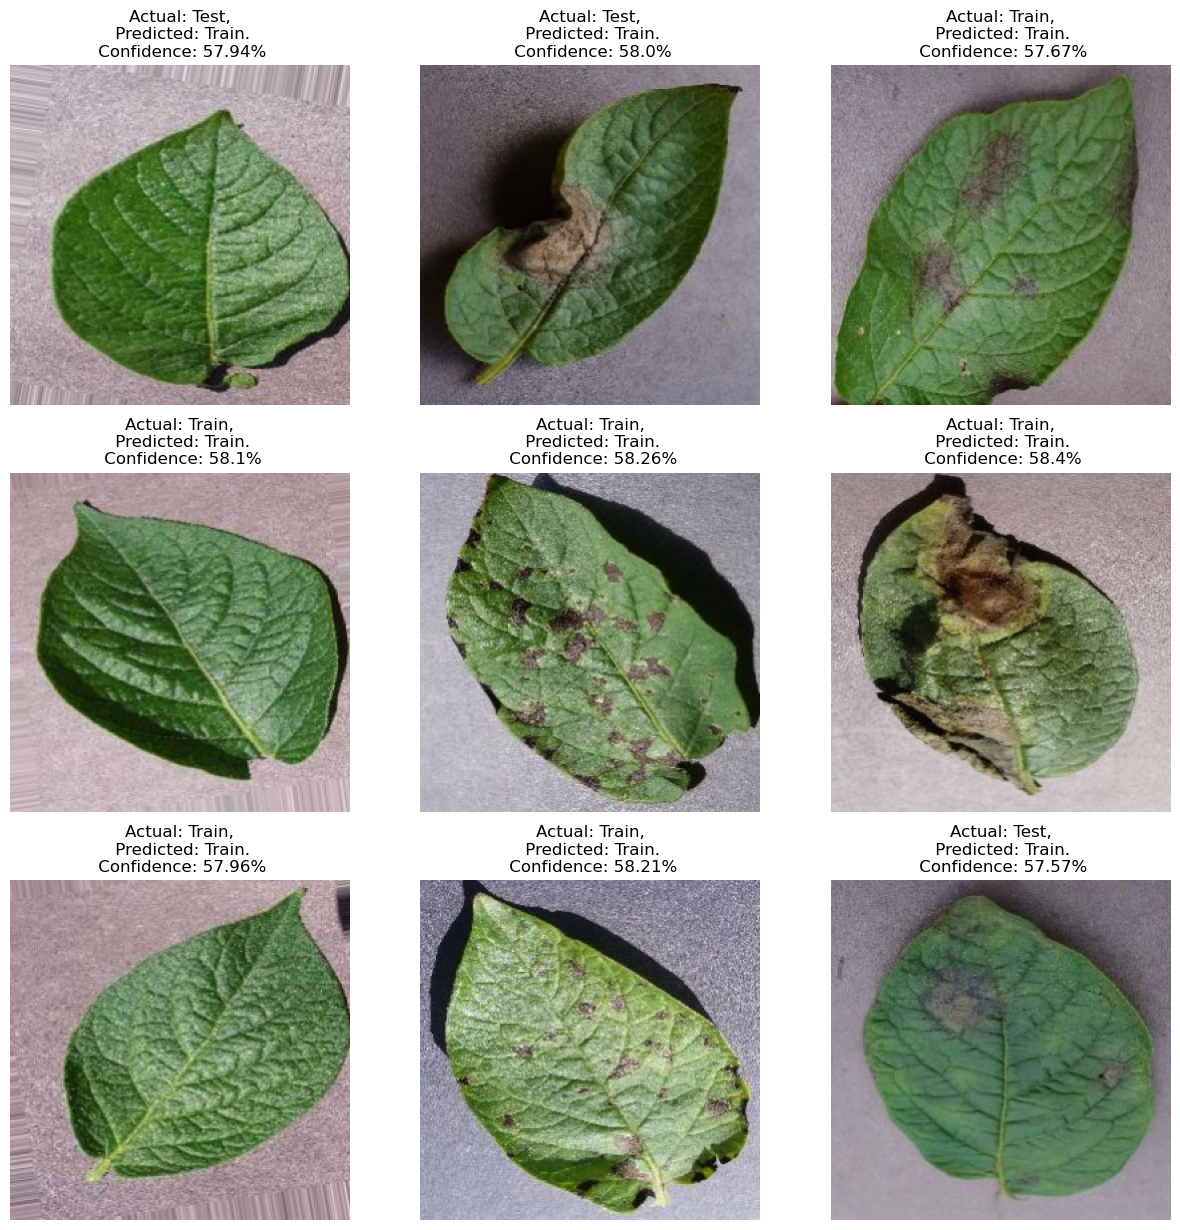

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")